## ALL imports

In [3]:
from channels.ina_nygren_testing_only_exp_with_data import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde

def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','sodium_current.i_Na','sodium_current.m_infinity_cube','sodium_current.h_infinity','membrane.V']))
        except:
            # Failed simulation
            del(data)
            return None
    return data

def pyabc_simulate(pars):
    res = simulate_model(**pars)
    return res

logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [4]:
# limits steady state
#limits = {'sodium_current.P_Na' : (0.000001,0.0001),
#          'sodium_current.q1': (0,100),
#          'sodium_current.q2': (0,100),
#          'sodium_current.r1': (0,100),
#          'sodium_current.r2': (-50,50)}

#limits = {'sodium_current.q3': (0,20),
#          'sodium_current.q4': (0,50),
#          'sodium_current.q5': (0,20),
#          'sodium_current.q6': (0,20),
#          'sodium_current.q7': (0,20),
#          'sodium_current.q8': (0,20)}

limits = {'sodium_current.r3': (0,1),
          'sodium_current.r4': (0,100),
          'sodium_current.r5': (0,100),
          'sodium_current.r6': (0,0.01)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# database name and path
db_name = "nygren_Na_sakakibara_data_4_exp.db"
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), db_name))
print(db_path)

# population size 
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

abc = ABCSMC(models=pyabc_simulate,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.01),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}
abc_id = abc.new(db_path, obs)

DEBUG:ABC:ion channel weights: {'0': 1.381328550382083, '1': 1.381328550382083, '2': 1.381328550382083, '3': 1.381328550382083, '4': 1.381328550382083, '5': 0.10337577522571516, '6': 0.06424200422073144, '7': 0.07115466478878421, '8': 0.17751591423498678, '9': 1.381328550382083, '10': 1.381328550382083, '11': 1.3336965314033904, '12': 1.3336965314033904, '13': 1.3336965314033904, '14': 1.3336965314033904, '15': 1.3336965314033904, '16': 1.3336965314033904, '17': 0.09868160059573296, '18': 0.08040678177425462, '19': 0.09867912458016163, '20': 1.3336965314033904, '21': 1.3336965314033904, '22': 1.3336965314033904, '23': 0.0895912568330299, '24': 0.17638278689002757, '25': 0.24540213828177754, '26': 0.40316065574863447, '27': 1.2860645124246979, '28': 1.2860645124246979, '29': 1.2860645124246979, '30': 1.2860645124246979, '31': 1.2860645124246979, '32': 1.2860645124246979, '33': 1.2860645124246979, '34': 1.2860645124246979, '35': 1.2860645124246979, '36': 1.2860645124246979, '37': 1.28606

sqlite:////tmp/nygren_Na_sakakibara_data_4_exp.db
Theoretical minimum population size is 16 particles


INFO:History:Start <ABCSMC(id=4, start_time=2019-06-26 13:29:35.292182, end_time=None)>


In [5]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 1011
DEBUG:Epsilon:new eps, t=1, eps=0.6059304688773115
INFO:ABC:t:1 eps:0.6059304688773115
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 3081
DEBUG:Epsilon:new eps, t=2, eps=0.3497833655027733
INFO:ABC:t:2 eps:0.3497833655027733
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 5115
DEBUG:Epsilon:new eps, t=3, eps=0.30286381174912824
INFO:ABC:t:3 eps:0.30286381174912824
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 7395
DEBUG:Epsilon:new eps, t=4, eps=0.29928853455803367
INFO:ABC:t:4 eps:0.29928853455803367
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 10357
DEBUG:Epsilon:new eps, t=5, eps=0.29694566

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

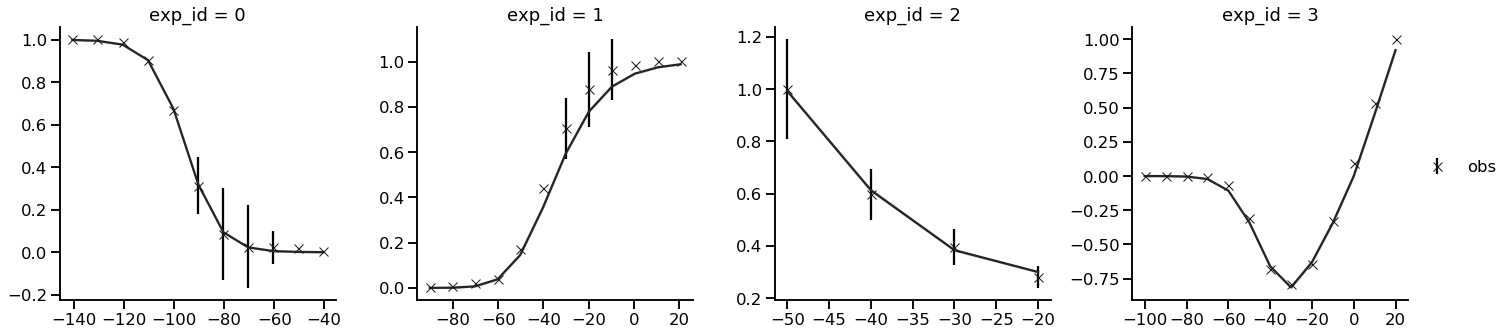

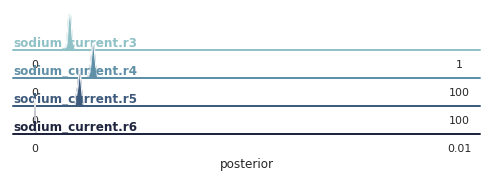

In [6]:
history = History(db_path)
history.all_runs()
history.id = 4  #nygren_Na_sakakibara_data_4_exp.db :
                #id = 1 : steady state parameters , id = 2 : tau_h (1 and 2) , id = 4 : tau_m
df, w = history.get_distribution(m=0)

# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')
plotting_obs = observations.copy()

# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(pyabc_simulate(pars=th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp_id': plotting_obs.exp_id})
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

sns.set_context('talk')


grid1 = plot_sim_results(samples, obs=plotting_obs)
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [7]:
grid1.savefig('results/ina_nygren/4_exp Sakakibara data/ina_nygren_sim_results_4exp_tau_m.pdf')
grid2.savefig('results/ina_nygren/4_exp Sakakibara data/ina_nygren_posterior_4exp_tau_m.pdf')

In [8]:
df.describe()

name,sodium_current.r3,sodium_current.r4,sodium_current.r5,sodium_current.r6
count,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,0.082490,13.784653,10.585293,9.923002e-06
std,0.003891,0.349436,0.347585,7.728310e-06
min,0.069116,12.731198,9.467129,2.577791e-08
25%,0.079911,13.553502,10.373963,3.918175e-06
50%,0.082461,13.795326,10.600954,7.863255e-06
75%,0.084923,14.022525,10.824057,1.507002e-05
max,0.095017,15.022354,11.392197,3.794431e-05
